In [1]:
import finetune_wav2vec2_utils as w2v2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchaudio
from torchaudio import transforms
from torch.utils.data import DataLoader
import numpy as np
import os

/home/sirjanh/miniconda3/envs/FrontERAAssignment/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-02-24 00:47:39.925076: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-24 00:47:40.008092: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-24 00:47:40.008657: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-24 00:47:40.133375: I tensorflow/core/platform/cpu_feature_guard.cc:210] 

In [2]:
from transformers import Wav2Vec2Model, Wav2Vec2Processor
import pandas as pd

In [3]:
csv_file = "./dataClassified/data.csv"

In [4]:
import finetune_wav2vec2_utils as w2v2

In [5]:
from torch.utils.data import Dataset, DataLoader

In [6]:
# Create dataset and DataLoader
dataset = w2v2.SoundDatasetFromCSV(csv_file, augment_audio=False)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

In [7]:
from tqdm import tqdm

In [8]:
# If the files are already processed, load them
if os.path.exists("embeds_w2v2.npy") and os.path.exists("labels_w2v2.npy"):
    X = np.load("embeds_w2v2.npy")
    y = np.load("labels_w2v2.npy")
else:
    X, y = [], []
    for embeddings, label in tqdm(dataloader, desc="Extracting embeddings"):
        X.extend(embeddings.numpy())
        y.extend(label.numpy())

    X = np.array(X)
    y = np.array(y)
    np.save("embeds_w2v2.npy", X)
    np.save("labels_w2v2.npy", y)


In [9]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report

# Assuming X (embeddings) and y (labels) are already defined as NumPy arrays

# Step 1: Split data into training+validation (85%) and test set (15%)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)


In [10]:
X_temp, X_val, y_temp, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp)

In [11]:
# Step 2: Perform k-fold cross-validation on the training+validation set
k = 5  # Number of folds
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
clf = LogisticRegression(max_iter=1000)



In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Define a simple Neural Network
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.model(x)

# Convert data to PyTorch tensors
X_temp_tensor = torch.tensor(X_temp, dtype=torch.float32)
y_temp_tensor = torch.tensor(y_temp, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Hyperparameters
input_dim = X_temp.shape[1]
hidden_dim = 128
output_dim = len(np.unique(y_temp))
epochs = 50
batch_size = 32
learning_rate = 0.001

# Step 2: Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

# Initialize lists to store the history
# Initialize lists to store the overall accuracies and errors for each epoch
train_accuracies = []
val_accuracies_overall = []
train_errors = []
val_errors_overall = []

# Training loop for Stratified K-Fold
for fold, (train_idx, val_idx) in enumerate(skf.split(X_temp, y_temp)):
    print(f"Fold {fold + 1}")

    # Data for the fold
    X_train_fold = X_temp_tensor[train_idx]
    y_train_fold = y_temp_tensor[train_idx]
    X_val_fold = X_temp_tensor[val_idx]
    y_val_fold = y_temp_tensor[val_idx]

    # Initialize model, loss, and optimizer
    model = SimpleNN(input_dim, hidden_dim, output_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    fold_train_accuracies = []  # To track training accuracy for each epoch of this fold
    fold_val_accuracies = []  # To track validation accuracy for each epoch of this fold
    fold_train_losses = []  # To track training loss for each epoch of this fold
    fold_val_losses = []  # To track validation loss for each epoch of this fold

    # Training loop
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_fold)
        loss = criterion(outputs, y_train_fold)
        loss.backward()
        optimizer.step()

        # Calculate training accuracy
        _, train_preds = torch.max(outputs, 1)
        train_accuracy = accuracy_score(y_train_fold.numpy(), train_preds.numpy())
        fold_train_accuracies.append(train_accuracy)
        fold_train_losses.append(loss.item())

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_fold)
            val_preds = torch.argmax(val_outputs, dim=1)
            val_loss = criterion(val_outputs, y_val_fold)
            val_accuracy = accuracy_score(y_val_fold.numpy(), val_preds.numpy())
            fold_val_accuracies.append(val_accuracy)
            fold_val_losses.append(val_loss.item())

    # Store fold's history
    train_accuracies.append(fold_train_accuracies)
    val_accuracies_overall.append(fold_val_accuracies)
    train_errors.append(fold_train_losses)
    val_errors_overall.append(fold_val_losses)



Fold 1
Fold 2
Fold 3
Fold 4
Fold 5


In [19]:
# Save this model
torch.save(model.state_dict(), "w2v2_nn.pth")

In [22]:
test_preds = model(X_test_tensor).detach().numpy()

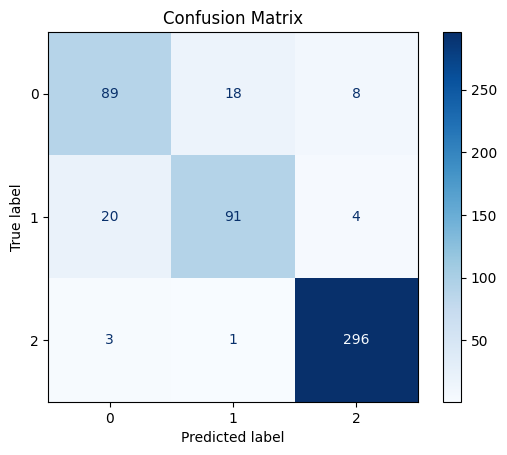

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Ensure test_outputs is a tensor
test_outputs = torch.tensor(test_preds) if not isinstance(test_preds, torch.Tensor) else test_outputs

# Get the predicted class labels
_, test_preds = torch.max(test_outputs, 1)

# Convert test_preds and y_test to numpy arrays for compatibility with scikit-learn
test_preds = test_preds.numpy()
y_test = y_test_tensor.numpy()

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, test_preds)
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


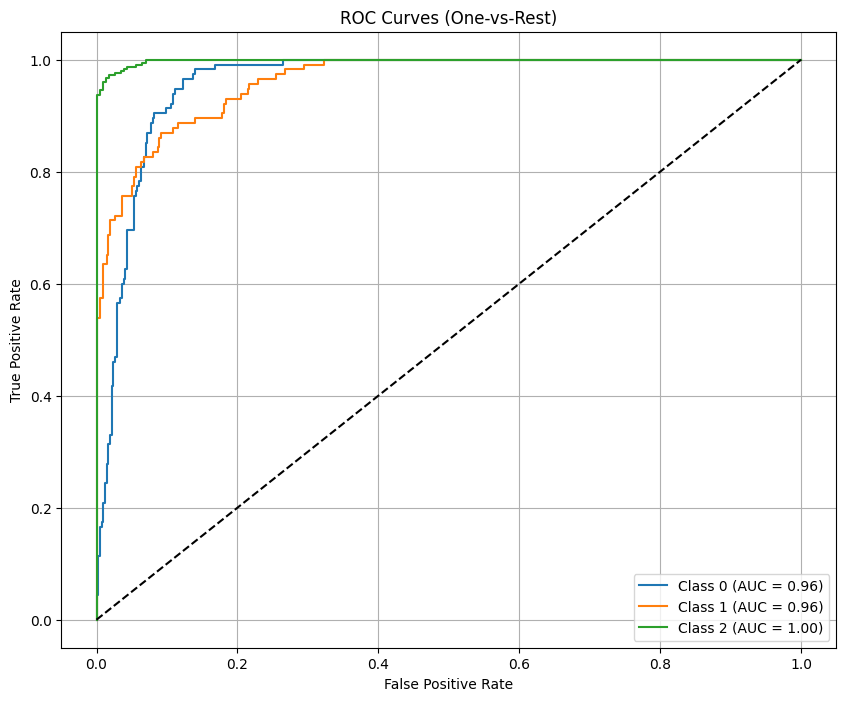

In [15]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize labels for multi-class ROC
n_classes = len(np.unique(y_test))
y_test_bin = label_binarize(y_test, classes=range(n_classes))
test_probs = nn.Softmax(dim=1)(test_outputs).numpy()  # Convert logits to probabilities

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], test_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest)")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [16]:
from sklearn.metrics import classification_report

print("\nClassification Report:\n", classification_report(y_test, test_preds.numpy()))



Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.77      0.78       115
           1       0.82      0.79      0.81       115
           2       0.96      0.99      0.98       300

    accuracy                           0.90       530
   macro avg       0.86      0.85      0.85       530
weighted avg       0.89      0.90      0.90       530



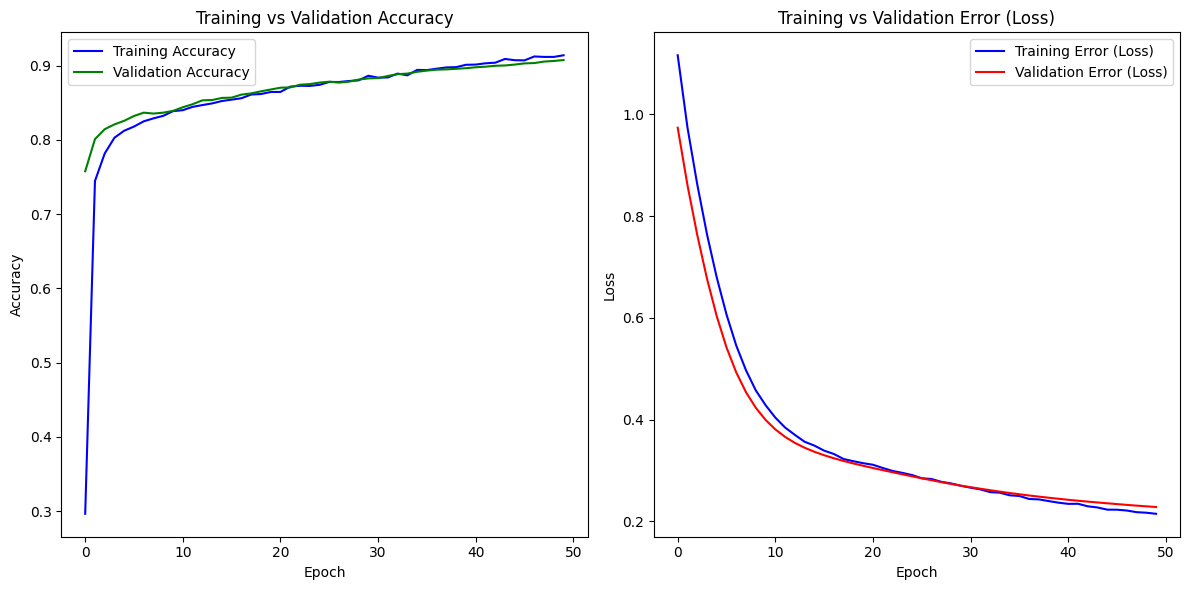

In [28]:
# Now, plot the overall accuracy and error
# Average the results across folds for overall plot
avg_train_accuracies = np.mean(train_accuracies, axis=0)
avg_val_accuracies = np.mean(val_accuracies_overall, axis=0)
avg_train_errors = np.mean(train_errors, axis=0)
avg_val_errors = np.mean(val_errors_overall, axis=0)

# Plotting training and validation accuracies
plt.figure(figsize=(12, 6))

# Plot accuracies
plt.subplot(1, 2, 1)
plt.plot(avg_train_accuracies, label='Training Accuracy', color='b')
plt.plot(avg_val_accuracies, label='Validation Accuracy', color='g')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation errors (losses)
plt.subplot(1, 2, 2)
plt.plot(avg_train_errors, label='Training Error (Loss)', color='b')
plt.plot(avg_val_errors, label='Validation Error (Loss)', color='r')
plt.title('Training vs Validation Error (Loss)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Perform on test set
model.eval()
test_outputs = model(X_test_tensor)
_, test_preds = torch.max(test_outputs, 1)
test_accuracy = accuracy_score(y_test_tensor.numpy(), test_preds.numpy())
print(f"Test Accuracy: {test_accuracy:.4f}")
